We will be using two different image datasets in this notebook:
1. the MNIST dataset
2. the CIFAR-10 dataset

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/UCB Files/2024Spring/IEOR242B/Notebooks/Discussion Lab/Week 4') # customize this line to your working directory

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set the random seed for reproducibility
torch.manual_seed(12345)

# Create data subdirectory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # shift your data range to [-1,1]
])

# Download and load the MNIST training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the MNIST test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
# length of the training and test datasets
print(f"Length of the training dataset: {len(trainset)}")
print(f"Length of the test dataset: {len(testset)}")

Length of the training dataset: 60000
Length of the test dataset: 10000


In [ ]:
# label counts
import pandas as pd

# Training data
train_labels = [label for _, label in trainset]
train_labels = pd.Series(train_labels)
print("Training label counts:")
print(train_labels.value_counts())

# Test data
test_labels = [label for _, label in testset]
test_labels = pd.Series(test_labels)
print("Test label counts:")
print(test_labels.value_counts())

Training label counts:
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64
Test label counts:
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


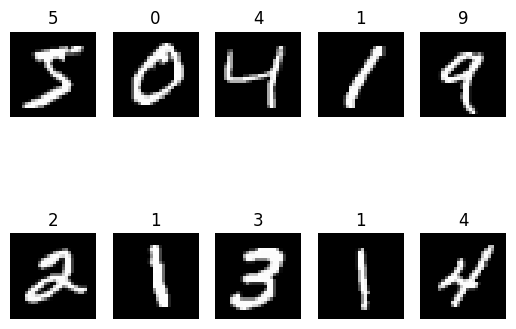

In [ ]:
# Show the first 10 images and labels from the training set
import matplotlib.pyplot as plt

for i in range(10):
    image, label = trainset[i]
    image = image.squeeze()  # Squeeze the image tensor to remove the extra dimension
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(label)

The most dominant class is '1'. Therefore the baseline accuracy can be computed as:

In [ ]:
print('baseline_acc =', 1135/len(testset))

baseline_acc = 0.1135


In [ ]:
# get the first image and label from the training set
image, label = trainset[0]
image.shape # c, h, w

torch.Size([1, 28, 28])

In [ ]:
image[0,:]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

In [ ]:
import time


# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            # check if cuda is available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, test_loader):

  train_loss_log = []
  train_acc_log = []
  test_acc_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    train_loss = 0
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y,y)
      # Zero the gradient of the optimizer
      optimizer.zero_grad()
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights
      optimizer.step()
      train_loss += loss.item() * len(x)
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss/=len(train_loader)
    train_loss_log.append(train_loss)
    train_acc = calculate_accuracy(train_loader, model)
    test_acc = calculate_accuracy(test_loader, model)
    train_acc_log.append(train_acc)
    test_acc_log.append(test_acc)
    print("Epoch {:2},  Training Loss: {:9.4f}, Training Accuracy: {:9.2f},  Test Accuracy: {:7.2f}".format(epoch, train_loss, train_acc, test_acc))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, train_acc_log, test_acc_log

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple neural network with three hidden layers
class TwoHiddenLayerNN(nn.Module):
    def __init__(self):
        super(TwoHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 10)     # Output layer
        # number of output nodes should equal to number
        # of labels since we are using cross entropy loss

    def forward(self, x):
        x = torch.flatten(x, 1)          # Flatten the images
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
two_hidden_nn = TwoHiddenLayerNN()
epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(two_hidden_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(two_hidden_nn, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   62.4645, Training Accuracy:     66.38,  Test Accuracy:   66.16
Epoch  2,  Training Loss:   53.6395, Training Accuracy:     67.44,  Test Accuracy:   67.13
Epoch  3,  Training Loss:   51.6442, Training Accuracy:     67.69,  Test Accuracy:   66.96
Epoch  4,  Training Loss:   49.1953, Training Accuracy:     78.42,  Test Accuracy:   78.13
Epoch  5,  Training Loss:   33.9789, Training Accuracy:     78.91,  Test Accuracy:   78.19
Elapsed Time :  139.11


In [ ]:
# Define a function that plots the training loss, training acc, and test acc history
# plot each in separate subplots
def visualizing_tool(train_loss_log, train_acc_log, test_acc_log):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    # plot scatter as well
    ax[0].scatter(range(len(train_loss_log)), train_loss_log, s=10)
    ax[0].plot(train_loss_log)
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].scatter(range(len(train_acc_log)), train_acc_log, s=10)
    ax[1].plot(train_acc_log)
    ax[1].set_title('Training Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[2].scatter(range(len(test_acc_log)), test_acc_log, s=10)
    ax[2].plot(test_acc_log)
    ax[2].set_title('Test Accuracy')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

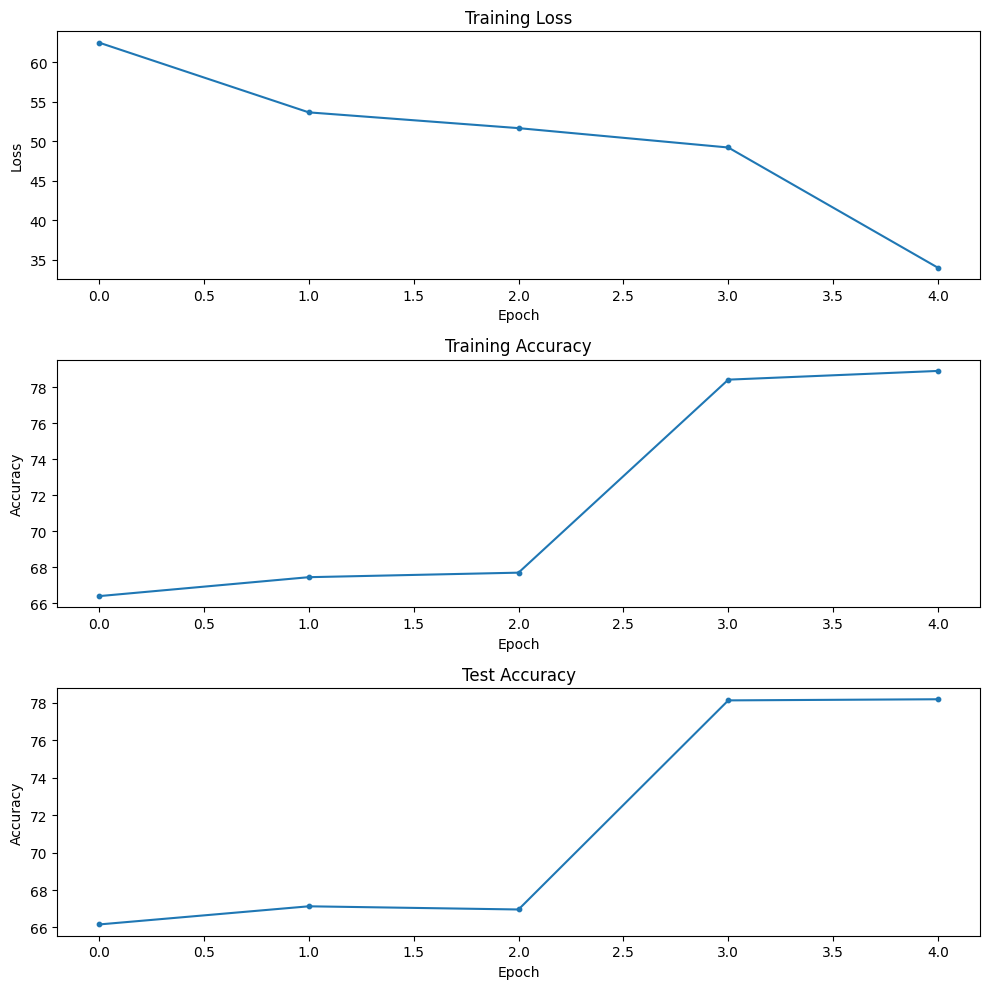

In [ ]:
visualizing_tool(train_loss_log, train_acc_log, test_acc_log)

In [ ]:
# Print out the model summary, including the number of parameters
print(two_hidden_nn)
# Print out the total number of parameters in the model
print(f"Total number of parameters in the model: {sum(p.numel() for p in two_hidden_nn.parameters())}")

TwoHiddenLayerNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Total number of parameters in the model: 407050


In [ ]:
# Build ThreeHiddenLayerNN
class ThreeHiddenLayerNN(nn.Module):
    def __init__(self):
        super(ThreeHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 512)    # Second hidden layer
        self.fc3 = nn.Linear(512, 10)     # Output layer

    def forward(self, x):
        x = torch.flatten(x, 1)          # Flatten the images
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
three_hidden_nn = ThreeHiddenLayerNN()
epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(three_hidden_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(three_hidden_nn, loss_func, epoch, optimizer, trainloader, testloader)



Epoch  1,  Training Loss:   50.3606, Training Accuracy:     76.49,  Test Accuracy:   76.47
Epoch  2,  Training Loss:   27.3311, Training Accuracy:     86.31,  Test Accuracy:   86.06
Epoch  3,  Training Loss:   21.9231, Training Accuracy:     87.54,  Test Accuracy:   87.18
Epoch  4,  Training Loss:   20.4804, Training Accuracy:     87.98,  Test Accuracy:   87.60
Epoch  5,  Training Loss:   19.8688, Training Accuracy:     88.06,  Test Accuracy:   87.43
Elapsed Time :  140.77


In [ ]:
# Print out the model summary, including the number of parameters
print(three_hidden_nn)
# Print out the total number of parameters in the model
print(f"Total number of parameters in the model: {sum(p.numel() for p in three_hidden_nn.parameters())}")


ThreeHiddenLayerNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)
Total number of parameters in the model: 669706


In [ ]:
# Build a three layer convolutional neural network
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1) # second convolutional layer

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(5*5*64, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
conv_nn = ConvolutionalNN()
epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(conv_nn, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   10.3610, Training Accuracy:     98.52,  Test Accuracy:   98.19
Epoch  2,  Training Loss:    3.0748, Training Accuracy:     98.56,  Test Accuracy:   98.18
Epoch  3,  Training Loss:    2.1230, Training Accuracy:     99.30,  Test Accuracy:   98.89
Epoch  4,  Training Loss:    1.5969, Training Accuracy:     99.44,  Test Accuracy:   98.89
Epoch  5,  Training Loss:    1.1730, Training Accuracy:     99.53,  Test Accuracy:   99.05
Elapsed Time :  151.79


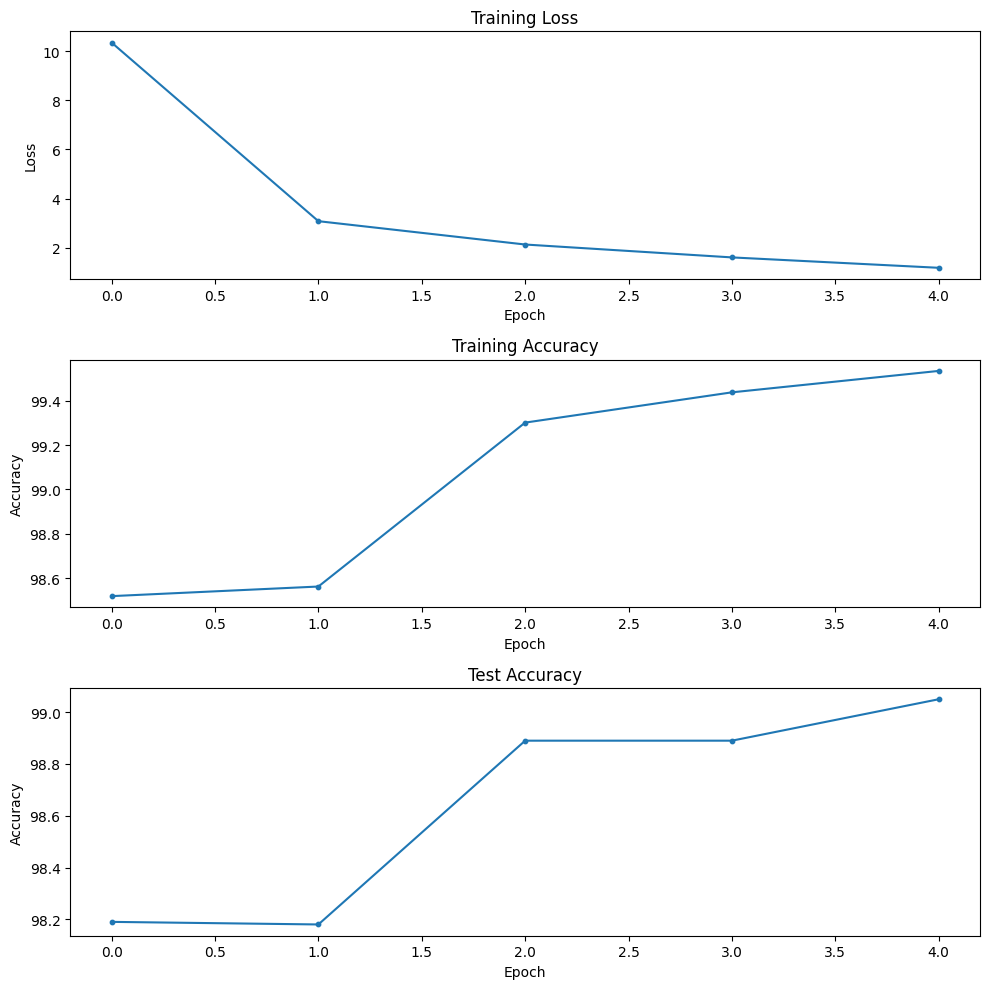

In [ ]:
visualizing_tool(train_loss_log, train_acc_log, test_acc_log)

In [ ]:
print(conv_nn)
print(f"Total number of parameters in the model: {sum(p.numel() for p in conv_nn.parameters())}")

ConvolutionalNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of parameters in the model: 225034


## Overfitting in the small dataset

In [ ]:
# Experiement with smaller dataset
# Create a smaller training set
small_trainset = torch.utils.data.Subset(trainset, range(100))
small_trainloader = torch.utils.data.DataLoader(small_trainset, batch_size=64, shuffle=True)
small_testset = torch.utils.data.Subset(testset, range(100))
small_testloader = torch.utils.data.DataLoader(small_testset, batch_size=64, shuffle=False)

In [ ]:
# Train the convolutional neural network on the smaller dataset
small_conv_nn = ConvolutionalNN()
epoch = 30
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(small_conv_nn.parameters(), lr=1e-3)
train_loss_log, train_acc_log, test_acc_log = train_model(small_conv_nn, loss_func, epoch, optimizer, small_trainloader, small_testloader)

Epoch  1,  Training Loss:  114.1895, Training Accuracy:     32.00,  Test Accuracy:   23.00
Epoch  2,  Training Loss:  106.8100, Training Accuracy:     53.00,  Test Accuracy:   46.00
Epoch  3,  Training Loss:   96.7084, Training Accuracy:     65.00,  Test Accuracy:   57.00
Epoch  4,  Training Loss:   84.3408, Training Accuracy:     71.00,  Test Accuracy:   62.00
Epoch  5,  Training Loss:   69.6827, Training Accuracy:     86.00,  Test Accuracy:   66.00
Epoch  6,  Training Loss:   55.0259, Training Accuracy:     89.00,  Test Accuracy:   65.00
Epoch  7,  Training Loss:   42.5374, Training Accuracy:     86.00,  Test Accuracy:   67.00
Epoch  8,  Training Loss:   31.9590, Training Accuracy:     93.00,  Test Accuracy:   70.00
Epoch  9,  Training Loss:   23.2209, Training Accuracy:     94.00,  Test Accuracy:   71.00
Epoch 10,  Training Loss:   18.9107, Training Accuracy:     94.00,  Test Accuracy:   73.00
Epoch 11,  Training Loss:   12.8950, Training Accuracy:     97.00,  Test Accuracy:   70.00

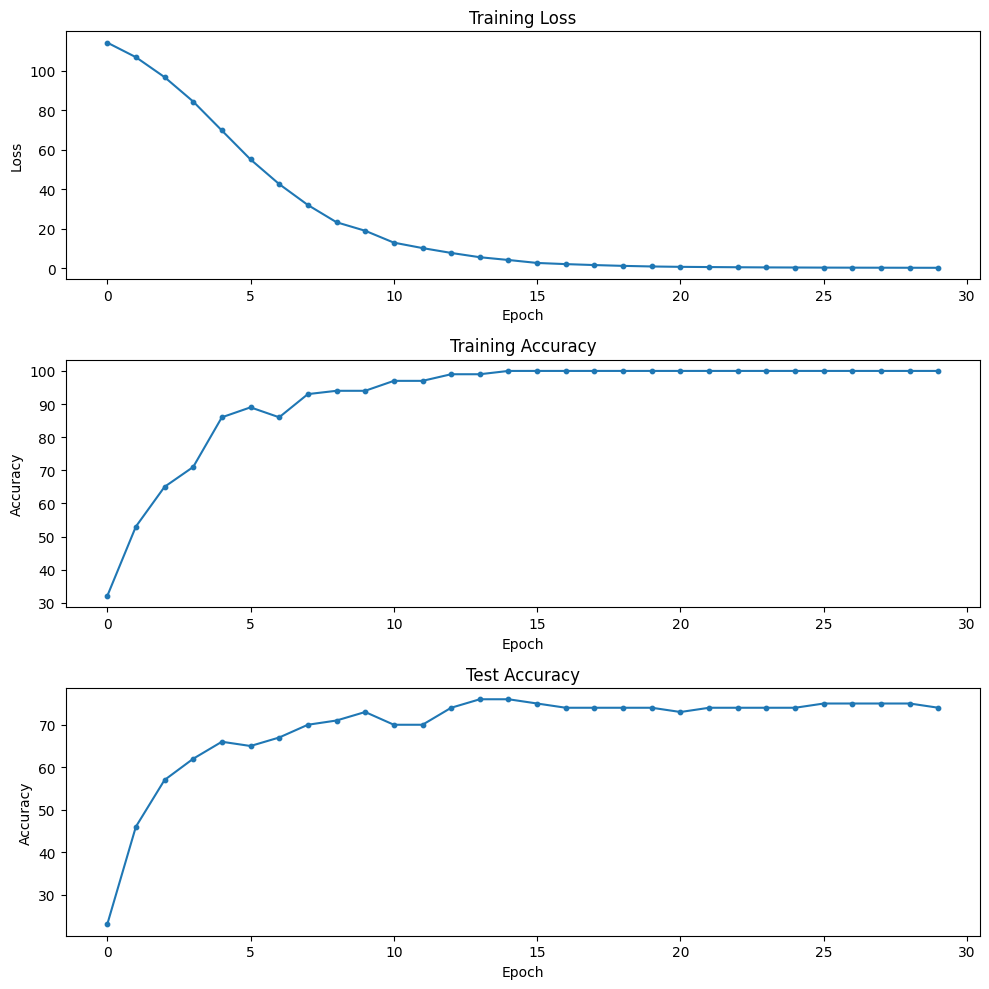

In [ ]:
visualizing_tool(train_loss_log, train_acc_log, test_acc_log)

Let us use different dataset: CIFAR10

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the images
])

# Load CIFAR-10 training data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load CIFAR-10 test data
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now, train_loader and test_loader can be used in your training and testing loops.


100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


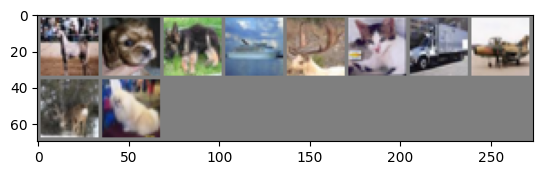

horse dog dog ship deer cat truck plane deer dog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images and labels
imshow(torchvision.utils.make_grid(images[:10]))  # Show first 10 images
print(' '.join(f'{classes[labels[j]]}' for j in range(10)))


In [ ]:
# length of the training and test datasets
print(f"Length of the training dataset: {len(train_dataset)}")
print(f"Length of the test dataset: {len(test_dataset)}")


Length of the training dataset: 50000
Length of the test dataset: 10000


In [ ]:
# print out the shape of the images
print(train_dataset[0][0].shape)

torch.Size([3, 32, 32])


In [ ]:
# value counts of the labels
train_labels = [label for _, label in train_dataset]
train_labels = pd.Series(train_labels)
print("Training label counts:")
print(train_labels.value_counts())

test_labels = [label for _, label in test_dataset]
test_labels = pd.Series(test_labels)
print("Test label counts:")
print(test_labels.value_counts())


Training label counts:
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64
Test label counts:
3    1000
8    1000
0    1000
6    1000
1    1000
9    1000
5    1000
7    1000
4    1000
2    1000
Name: count, dtype: int64


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define Three Hidden Layer Network for CIFAR-10
class ThreeHiddenLayerNN_CIFAR10(nn.Module):
    def __init__(self):
        super(ThreeHiddenLayerNN_CIFAR10, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)  # First hidden layer
        self.fc2 = nn.Linear(512, 512)      # Second hidden layer
        self.fc3 = nn.Linear(512, 10)       # Output layer

    def forward(self, x):
        x = torch.flatten(x, 1)            # Flatten the images
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


In [ ]:
# Initialize the model, loss function, and optimizer
three_hidden_nn_cifar10 = ThreeHiddenLayerNN_CIFAR10()
epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(three_hidden_nn_cifar10.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(three_hidden_nn_cifar10, loss_func, epoch, optimizer, train_loader, test_loader)

Epoch  1,  Training Loss:  128.4192, Training Accuracy:     36.29,  Test Accuracy:   35.09
Epoch  2,  Training Loss:  119.4791, Training Accuracy:     39.78,  Test Accuracy:   37.06
Epoch  3,  Training Loss:  108.8397, Training Accuracy:     46.05,  Test Accuracy:   41.56
Epoch  4,  Training Loss:  102.8269, Training Accuracy:     47.96,  Test Accuracy:   42.61
Epoch  5,  Training Loss:   98.8411, Training Accuracy:     50.67,  Test Accuracy:   43.24
Elapsed Time :  145.09


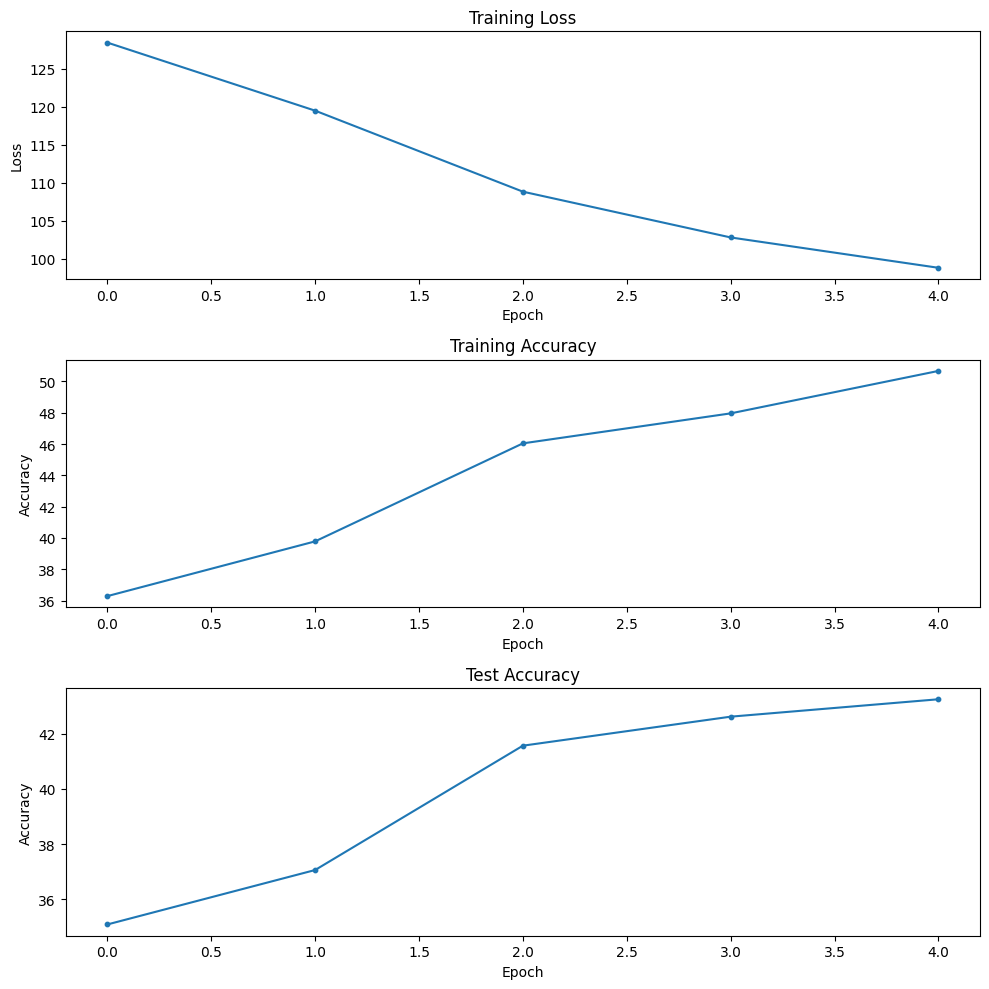

In [ ]:
visualizing_tool(train_loss_log, train_acc_log, test_acc_log)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()

        # Build a CNN with 3 convolutional layers and 2 fully connected layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Define a Pooling layer
        self.pool = nn.MaxPool2d(2,2)

        # Define Fully connected layers
        self.fc1 = nn.Linear(4*4*64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # Apply convolutions and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Final layer without ReLU activation
        x = self.fc3(x)

        return x


In [ ]:
# Train on the smaller CIFAR-10 dataset
small_train_set = torch.utils.data.Subset(train_dataset, range(100))
small_train_loader = torch.utils.data.DataLoader(small_train_set, batch_size=64, shuffle=True)
small_test_set = torch.utils.data.Subset(test_dataset, range(100))
small_test_loader = torch.utils.data.DataLoader(small_test_set, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
cnn_cifar10 = CNN_CIFAR10()
epoch = 50
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_cifar10.parameters(), lr=1e-2)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(cnn_cifar10, loss_func, epoch, optimizer, small_train_loader, small_test_loader)


Epoch  1,  Training Loss:  217.9274, Training Accuracy:     12.00,  Test Accuracy:   11.00
Epoch  2,  Training Loss:  115.9893, Training Accuracy:     15.00,  Test Accuracy:   11.00
Epoch  3,  Training Loss:  115.4284, Training Accuracy:     13.00,  Test Accuracy:    8.00
Epoch  4,  Training Loss:  116.8373, Training Accuracy:     12.00,  Test Accuracy:   11.00
Epoch  5,  Training Loss:  113.4882, Training Accuracy:     12.00,  Test Accuracy:   11.00
Epoch  6,  Training Loss:  113.1480, Training Accuracy:     16.00,  Test Accuracy:    6.00
Epoch  7,  Training Loss:  111.8214, Training Accuracy:     19.00,  Test Accuracy:    8.00
Epoch  8,  Training Loss:  111.4371, Training Accuracy:     20.00,  Test Accuracy:    7.00
Epoch  9,  Training Loss:  110.5752, Training Accuracy:     19.00,  Test Accuracy:   10.00
Epoch 10,  Training Loss:  109.0524, Training Accuracy:     21.00,  Test Accuracy:   14.00
Epoch 11,  Training Loss:  107.8052, Training Accuracy:     24.00,  Test Accuracy:   13.00

In [ ]:
# Initialize the model, loss function, and optimizer
cnn_cifar10 = CNN_CIFAR10()
epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_cifar10.parameters(), lr=0.001)

# Train the model
train_loss_log, train_acc_log, test_acc_log = train_model(cnn_cifar10, loss_func, epoch, optimizer, train_loader, test_loader)

Epoch  1,  Training Loss:   92.4209, Training Accuracy:     60.39,  Test Accuracy:   59.76
Epoch  2,  Training Loss:   64.5300, Training Accuracy:     70.07,  Test Accuracy:   66.87
Epoch  3,  Training Loss:   51.3254, Training Accuracy:     75.42,  Test Accuracy:   70.58
Epoch  4,  Training Loss:   42.8923, Training Accuracy:     81.60,  Test Accuracy:   72.94
Epoch  5,  Training Loss:   36.1827, Training Accuracy:     83.91,  Test Accuracy:   73.20
Elapsed Time :  161.48


In [ ]:
print(cnn_cifar10)

CNN_CIFAR10(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


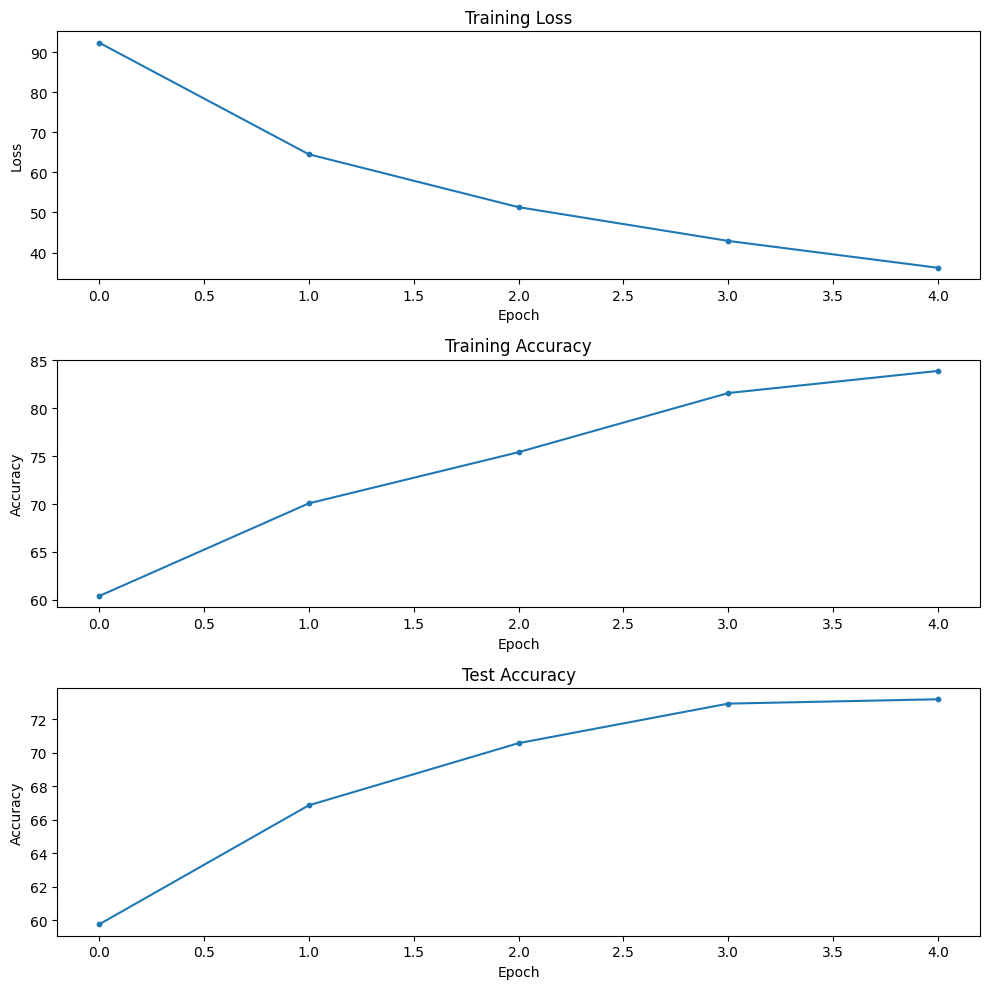

In [ ]:
visualizing_tool(train_loss_log, train_acc_log, test_acc_log)